In [110]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import odeint

%matplotlib inline

In [111]:
"""Constants"""
eps0 = 8.854e-12 #[F/m]
eps_rel = 1 #relative permittivity
eps = eps0 * eps_rel
k = 1/(4*math.pi*eps)
e = 1.60217662e-19 #elementary charge [C]
h = 6.62607004e-34 #Planck's constant [Js]
m_e = 9.10938356e-31 #electron mass [kg]

In [112]:
"""Initial parameter functions"""
def seperation_angle(n):
    return ( (2*math.pi)/n )

def setup_radius(sep, diam, PHI):
    return ( (sep + diam)/(2 * math.sin(PHI/2)) )

def cog_length( Rp, PHI):
    r = ( Rp*math.sin(PHI) )/(4*math.sin(PHI/2))
    return r

def width( Rp, PHI):
    w = ( Rp*math.sin(PHI) )/2
    return w

def intertia( rho, thc, Rp):
    """Calculates inertia of inner rotating disk"""
    I = 0.5 * rho * math.pi * thc * ( Rp ** 4 ) #for disc, needs to be changed for cog shape
    return I

In [113]:
"""Motor setup functions"""

def permanent_charge_magnitude( r, width, cap_d, cap_vol):
    """Calculates magnitude of total charge stored in inner segment"""
    segment_area = r * width
    capacitance = cap_d * segment_area #capacitance of one segment
    stored_charge = capacitance * cap_vol #stored charge in one segment
    return stored_charge

def permanent_charges( Rp, p , cap_d, cap_vol, width, r):
    """Initializes permanent charge elements"""
    PCs = {}
    for i in range(p):
        theta = (2*math.pi/p)*i
        xp = Rp*math.cos(theta)
        yp = Rp*math.sin(theta)
        if i%2 == 0:
            p_ch = permanent_charge_magnitude( r, width, cap_d, cap_vol)
        else:
            p_ch = -permanent_charge_magnitude( r, width, cap_d, cap_vol)
        PCs.update({i:[xp,yp,theta, p_ch]}) #dictionary containing all info of permanent charges
    return PCs

def quantum_dots( n, e, noc):
    """Initializes quantum dot elements"""
    QDs = {}
    for i in range(n):
        fi = (2*math.pi/n)*i
        x = R*math.cos(fi)
        y = R*math.sin(fi)
        if i in range(1, n, 4): #will result in +ve torque ==> turning anti-clockwise
            q_ch = noc*e
        elif i in range(3, n, 4):
            q_ch = -noc*e
        else:
            q_ch = 0
        QDs.update({i:[x,y,fi,q_ch]}) #dictionary containing all info on QDs
    return QDs

In [114]:
"""Active motor functions"""

def tangential_component(n, e, R, r0, gamma, noc):
    """Calculates the tangential coulomb force on one inner charge"""
    F_c = 0; #coulomb force
    F_t = 0 #tangential component of coulumb force
    QDs = quantum_dots(n, e, noc) #calls function to initialize QDs
    for i in range(n):
        Q = QDs[i] #dictionary section on ith QD
        ri = math.sqrt(2*R*(R-r0)*(1-math.cos(QDs[i][2]-gamma))+r0**2) #distance between QD and permanent charge
        F_c = k*PCs[0][3]*Q[3]/(ri**2) #coulomb force between permanent charge and QD
        d = 2*R*math.sin((QDs[i][2]-gamma)/2)
        if (((r0**2)+(ri**2)-(d**2))/(2*r0*ri)) > 1 or (((r0**2)+(ri**2)-(d**2))/(2*r0*ri)) < -1 : #accounts for computational error
            alpha = 0
        else:
            alpha = math.acos(((r0**2)+(ri**2)-(d**2))/(2*r0*ri)) #angle to tangential in which force vector acts
        if i > n/2:
            alpha = -alpha
        F_t += F_c*math.sin(alpha)
    return F_t

def torque (F_t, Rp, p):
    """Computes torque on enitre inner rotor"""
    torque = F_t * Rp * p
    return torque

def angular_velocity(angle_increment, v_ang, i, torque, inertia):
    """Calculates the angular velocity after rotating the angle increment"""
    w_f = 0
    w_f = math.sqrt( (v_ang[i])**2 + (2*torque*angle_increment)/inertia )
    return w_f

def time_step(inertia, torque, v_ang):
    """Calculates time taken to reach new v_ang"""
    tau = (v_ang[i] - v_ang[i-1])* inertia/torque
    return tau

def Charging_voltage_QD( n, e, Cdot):
    """Constant voltage required to maintain QD charge"""
    QDs = quantum_dots(n,e, noc) #calls function to initialize QDs
    voltage = ( QDs[0][3]/(2*Cdot) ) #voltage needed to add one electron
    return voltage

def QD_capacitance( eps, d):
    Cdot = 2*math.pi*eps*d
    return Cdot

def Charging_time( R, C):
    "Computes charging time for dot and capacitor"
    tc = 4 * R * C
    return tc

def Input_energy (n, e, Cdot, Rt, h, m_eeff, diam, E_g, m_heff, noc, cap_vol, R_c):
    """Input power for each step"""
    #for capacitor charging
    E_cC = (PCs[0][3] * cap_vol)
    #for -ve charged dots, energy corresponds to that needed to the required voltage to cause electrons to tunnel into the dot
    E_cQD = (Charging_voltage_QD( n, e, Cdot) * noc * e )
    #for +ve charged dots, energy corresponds to laser energy plus voltage emergy to make electrons tunnel out of the dot
    #laser energy depends on bandgap/energy level seperation
    if (noc % 2 == 0):
        J = noc/2
    else:
        J = (noc + 1)/2
    
    E_l = E_g + ((h**2)*J/(8*m_eeff*(diam**2))) + ((h**2)*J/(8*m_heff*(diam**2)))
    #print( E_cQD )
    #print( E_cC )
    E_intotal = (E_cQD * n) + ( (n/2) * (E_l + E_cC) )
    return E_intotal

def Output_power(angv, torque):
    return angv * torque

def Output_energy(angv, I):
    E_out = 0.5 * I * (angv**2)
    return E_out

def efficiency(E_in, E_out):
    eff = (E_out/E_in)
    return eff

In [115]:
"""Mathematical functions"""

def func(x, A, B, C, D, E, F, G, H):
    return A * (x**7) + B * (x**6) + C * (x**5)+ D * (x**4) + E * (x**3) + F * (x**2) + G * x + H 

def solvr( Y, t, params):
    const, A, B, C, D, E, F, G, H = params
    return [ Y[1], ( A * (Y[0]**7) + B * (Y[0]**6) + C * (Y[0]**5) + D * (Y[0]**4) + E * (Y[0]**3) + F * (Y[0]**2) + G * Y[0] + H - const * Y[1]) ]

In [116]:
"""Material dependant constants:"""
'''Fluid'''
fluid_density = 0.164 #helium
eta = 3.12e-5 #shear viscosity = kinematic viscosity * denisty of fluid
beta = 0 #bulk viscoisty
kinematic_viscosity = 3.12e-5/fluid_density

'''QDs'''
#(InAs/GaAs QDs)
Rt = (10*h)/(e**2) #tunneling resistance (made up value)
m_eeff = 0.067 * m_e #electron effective mass [kg]
m_heff = 0.34 * m_e #hole effective mass [kg]
E_g = 0.36 * 1.60217662e-19 #band gap of QD (InAs bulk) [J]


'''Inner section'''
cap_d = 0.394    #capacitance density in [F/m^2] of inner segment capacitors
rho = 3e3 # desity of inner disc material (approxmiate) [kg/m^3]
R_c = 1 #capacitor circuit resistance

In [117]:
'''Test lists'''
N = 401
n_list = []
p_list = []
phi_list = []
R_list = []
Rp_list = []
width_list = []
r_list = []
I_list = []
constant_list = []
step_list = []
angle_increment_list = []
A_list = []
B_list = []
C_list = []
D_list = []
E_list = []
F_list = []
G_list = []
H_list = []
color_list = ['b', 'g', 'r', 'c', 'm', 'y']

'''QDs'''
diam = 10e-9 #diameter of QDs [m]
sep = 130e-9 #seperation of QDs [m] (corresponds to motor dead zone)
noc = 6 #number of charge carriers contributing to net charge of QD
'''Inner section'''
r0 = 110e-9
thc = 30e-9   #approximate thickeness of inner disc [m]
cap_vol = 1   #applied voltage to capacitors in inner disck ("permanent charges"/charged segments) [V]
i=0
for n in np.arange(8, N, 4):
    PHI = seperation_angle(n) #angle of seperation between QDs
    phi_list.append(PHI)
    R = setup_radius(sep, diam, PHI)  #radius of QD setup [m] 5.36290830288e-07
    R_list.append(R)
    Rp = R - r0   #radius of rotating disc [m]
    Rp_list.append(Rp)
    w = width( Rp, PHI ) #cog "tooth"/capacitor arm width [m]
    width_list.append(w)
    r = cog_length( Rp, PHI)    #length of the cog shaft [m]
    r_list.append(r)
    I = intertia( rho, thc, Rp) #inertia of inner rotating disk
    I_list.append(I)
    p = int(n/2)
    p_list.append(p)
    n_list.append(n)
    constant =  p * 1.08037675928e-11  #coefficient of drag force function
    constant_list.append( constant )
    step = math.pi*(360/n)/180 #angle between each QD, angle required for one step
    step_list.append(step)
    angle_increment = step/100
    angle_increment_list.append( angle_increment )

In [118]:
i=0
for n in np.arange(8, N, 4):
    PCs = permanent_charges( Rp_list[i], p_list[i] , cap_d, cap_vol, width_list[i], r_list[i]) #initializes permanent charges
    T = []
    gamma_list = []
    for gamma in np.arange(0, step_list[i], angle_increment_list[i]): #iterates angle increment until one step is completed
        gamma_list.append( gamma )
        F_t = tangential_component(n_list[i], e, R_list[i], r0, gamma, noc)
        T.append( torque(F_t, Rp_list[i], p_list[i]) ) #calculates torque acting on inner rotor
    popt, pcov = curve_fit(func, gamma_list, T)
    A_list.append(popt[0])
    B_list.append(popt[1])
    C_list.append(popt[2])
    D_list.append(popt[3])
    E_list.append(popt[4])
    F_list.append(popt[5])
    G_list.append(popt[6])
    H_list.append(popt[7])
    
    i+=1

In [119]:
snipped_sol_list = []
keep_j_list = []
i=0
for n in np.arange(8, N, 4):
    params = [ ( (constant_list[i]*(Rp_list[i]/2))/(I_list[i]) ) , ( A_list[i]/(I_list[i]) ), ( B_list[i]/(I_list[i]) ), ( C_list[i]/(I_list[i]) ), (D_list[i]/(I_list[i]) ), ( E_list[i]/(I_list[i]) ), ( F_list[i]/(I_list[i]) ), ( G_list[i]/(I_list[i]) ), ( H_list[i]/(I_list[i]) ) ]
    tStop = 1
    tInc = 1e-6
    t_array = np.arange( 0, tStop, tInc)
    sol = odeint( solvr, [0,0], t_array, args=(params,) )
    keep_j = 0
    for j in np.arange( 0, len(t_array) ):
        if sol[j][0] >= step_list[i]:
            keep_j = j
            break
        else:
            keep_j = len(t_array)
    keep_j_list.append( keep_j )
    snipped_sol = np.zeros((keep_j, 2))
    snipped_sol = sol[:keep_j]
    snipped_sol_list.append( snipped_sol )
    i+=1

In [120]:
E_OUT_list = []
i=0
for n in np.arange(8, N, 4):
    snip_sol = snipped_sol_list[i]
    E_OUT = 0
    for j in np.arange( 0, len(snip_sol) ):
        p_out = Output_power(snip_sol[j][1], func(snip_sol[j][0], A_list[i], B_list[i], C_list[i], D_list[i], E_list[i], F_list[i], G_list[i], H_list[i]) )
        E_OUT += p_out * tInc
    E_OUT_list.append( E_OUT )
    i+=1

In [121]:
"""Computes input power"""
Cdot = QD_capacitance( eps, diam)
E_in_list = []
i=0
for n in np.arange(8, N, 4):
    PCs = permanent_charges( Rp_list[i], p_list[i] , cap_d, cap_vol, width_list[i], r_list[i])
    E_in = Input_energy (n_list[i], e, Cdot, Rt, h, m_eeff, diam, E_g, m_heff, noc, cap_vol, R_c)
    E_in_list.append( E_in )
    i+=1


8 2.4556855324
12 3.09460098723
16 3.35362236075
20 3.49279038366
24 3.57907313125
28 3.63735801938
32 3.67902316955
36 3.70994327625
40 3.7335010865
44 3.75176309747
48 3.76606332803
52 3.77728827193
56 3.78609881416
60 3.79294905427
64 3.79814417417
68 3.80195213263
72 3.80456649455
76 3.80614051417
80 3.80679414015
84 3.80662430265
88 3.80570902138
92 3.80411332597
96 3.80189036536
100 3.79908456183
104 3.79571395527
108 3.79186888009
112 3.78749871143
116 3.78270442292
120 3.77744747393
124 3.77176548559
128 3.76567385488
132 3.75918541103
136 3.7523110056
140 3.74506274613
144 3.73744899818
148 3.72947809839
152 3.72115697407
156 3.71249321634
160 3.70349131031
164 3.69415710078
168 3.68449538842
172 3.67451140507
176 3.66420749743
180 3.65358835575
184 3.64265629379
188 3.63141483262
192 3.61986716519
196 3.60801510121
200 3.59586082148
204 3.5834064467
208 3.57064248354
212 3.55760563985
216 3.54426221158
220 3.53062633665
224 3.51668646366
228 3.50247740948
232 3.4879689168
236

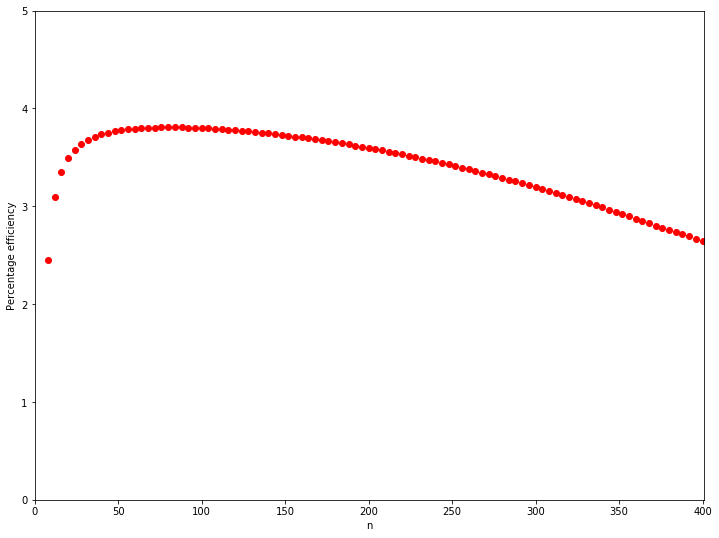

In [122]:
fig1 = plt.figure(figsize=(12, 9))
ax1 = fig1.add_subplot(111)
ax1.set_xlabel('n')
ax1.set_ylabel('Percentage efficiency')
ax1.set_ylim( 0 , 5 )
ax1.set_xlim( 0 , N )
eff_percent_list = []
i=0
for n in np.arange(8, N, 4):
    eff = efficiency( E_in_list[i], E_OUT_list[i] )
    print ( n, eff*100 )
    eff_percent_list.append( eff*100 )
    ax1.scatter( n_list[i], eff_percent_list[i], color='r' )
    i+=1